In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

inspector = inspect(engine)

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.

inspector = inspect(engine)
# names and types in tables
measurement_columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [31]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [34]:
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

most recent date in the data set is: 2017-08-23
date one year from the most recent date is 2016-08-23


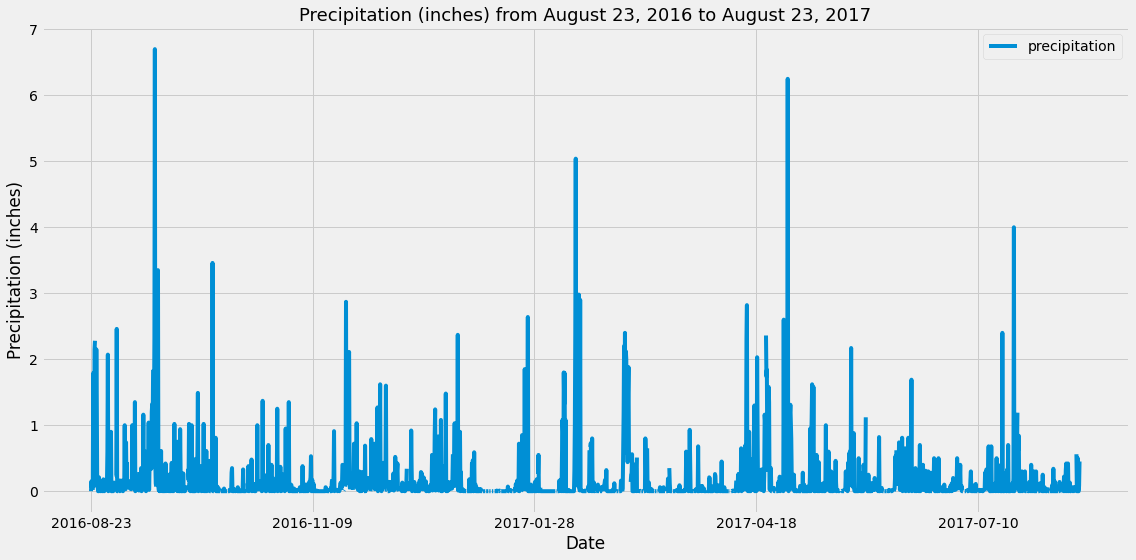

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(f"most recent date in the data set is: {most_recent_date}")
# Calculate the date one year from the last date in data set.
last_date = (dt.datetime.strptime(most_recent_date, "%Y-%m-%d")).date()
date_oneyearago = last_date - dt.timedelta(days=365)
print(f"date one year from the most recent date is {date_oneyearago}")


# Perform a query to retrieve the data and precipitation scores

precipitation_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= date_oneyearago).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_df = pd.DataFrame(precipitation_scores, columns = ['date', 'precipitation'])


# Sort the dataframe by date
precipitation_scores_df.set_index('date')


# Use Pandas Plotting with Matplotlib to plot the data
x = 'date'
y = 'precipitation'
precipitation_scores_df.plot(x,y, figsize=(16,8), fontsize=14)
plt.title(f"Precipitation (inches) from August 23, 2016 to August 23, 2017", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

plt.tight_layout()
plt.savefig("Images/percipitation_in_year.png")
plt.show()



In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number stations in the dataset
total_number_of_stations = session.query(station.id).count()
print(f"There are {total_number_of_stations} total number of stations in the dataset.")

There are 9 number of stations in the dataset.


In [53]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_stations = list(active_station_count)
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station =most_active_stations[0][0]
most_active_station

'USC00519281'

In [61]:
lowest_temperature = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

highest_temperature = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

average_temperature = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

#########################################################################################
print("Most Active Station Summary")
print("----------------------------------------")
print(f"Most active stations are {most_active_station}.")
print(f"Lowest Temperature: {lowest_temperature} Degrees")
print(f"Highest Temperature: {highest_temperature} Degrees")
print(f"Average Temperature: {average_temperature} Degrees")

Most Active Station Summary
----------------------------------------
Most active stations are USC00519281.
Lowest Temperature: 54.0 Degrees
Highest Temperature: 85.0 Degrees
Average Temperature: 71.66378066378067 Degrees


In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temp_obs = pd.DataFrame(session.query(measurement.tobs).\
                                            filter((measurement.station == most_active_station)
                                                   & (measurement.date >= date_oneyearago)
                                                   & (measurement.date <= last_date)).all(),
                                            columns = ['temperature observation'])
most_active_station_temp_obs.head()

,temperature observation
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


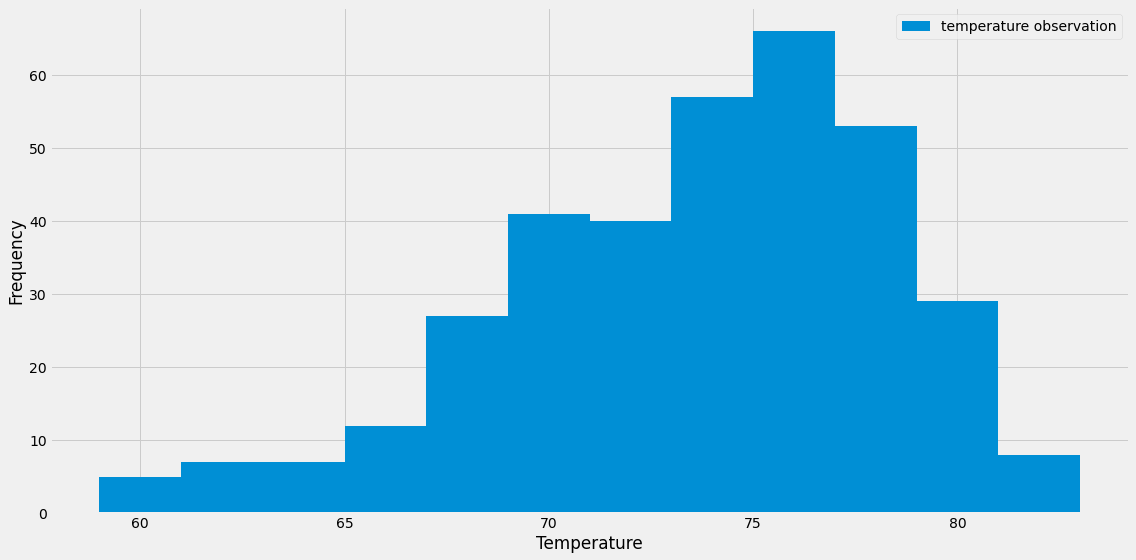

In [67]:
most_active_station_temp_obs.plot(kind = 'hist', bins = 12,figsize=(16,8),legend = True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Images/mst_actv_station_temp_observ.png")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()